In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

2024-06-27 14:35:09.876745: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the digits dataset
digits = load_digits()

# Extract features (X) and labels (y) from the dataset
X = digits['data']
y = digits['target']

# Print the shape of X and y to verify their dimensions
print(f'X.shape: {X.shape}')
print(f'y.shape: {y.shape}')

X.shape: (1797, 64)
y.shape: (1797,)


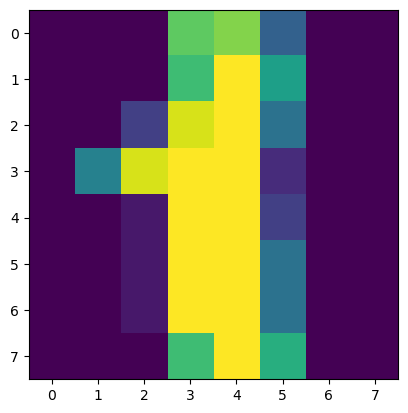

In [3]:
# Visualize a sample image from the dataset
plt.imshow(X[1].reshape(8, 8))

In [4]:
# Scale the features to the range [0, 1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
# Transpose the data to match the expected input shape for our model
X_train = X_train.T
X_test = X_test.T
y_train = tf.keras.utils.to_categorical(y_train).T

# Print the shapes of training and testing data to verify their dimensions
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (64, 1203)
X_test.shape: (64, 594)
y_train.shape: (10, 1203)
y_test.shape: (594,)


In [7]:
def initialize_parameters(layer_dims):
    """
    Initialize parameters for the neural network with multiple layers.
    
    Arguments:
    layer_dims -- list containing the number of units in each layer
    
    Returns:
    params -- dictionary containing initialized parameters
    """
    params = {}
    for i in range(1, len(layer_dims)):
        params[f'W{i}'] = tf.Variable(tf.random.normal(shape=(layer_dims[i], layer_dims[i-1])) * tf.sqrt(2/layer_dims[i-1]))
        params[f'b{i}'] = tf.Variable(tf.zeros(shape=(layer_dims[i], 1)))
    
    return params

In [8]:
def softmax(z):
    return tf.exp(z)/tf.reduce_sum(tf.exp(z), axis=0)

In [9]:
def forward_propagation(X, params):
    """
    Perform forward propagation to predict the output.
    
    Arguments:
    X -- input data of shape (n_x, m)
    params -- dictionary containing initialized parameters
    
    Returns:
    y_hat -- predicted output
    """
    l = len(params) // 2
    A = X
    for i in range(1, l):
        Z = params[f'W{i}'] @ A + params[f'b{i}']
        A = tf.nn.relu(Z)
    
    Z = params[f'W{l}'] @ A + params[f'b{l}']
    y_hat = softmax(Z)
    
    return y_hat

In [10]:
def compute_cost(y, y_hat):
    """
    Compute the cost using categorical cross-entropy.
    
    Arguments:
    y -- true labels
    y_hat -- predicted probabilities
    
    Returns:
    cost -- categorical cross-entropy cost
    """
    loss = tf.keras.losses.categorical_crossentropy(y, y_hat)
    return tf.reduce_sum(loss)

In [11]:
def gradient_descent(params, grads, learning_rate):
    """
    Update parameters using gradient descent.
    
    Arguments:
    params -- dictionary containing parameters
    grads -- dictionary containing gradients of the cost with respect to parameters
    learning_rate -- learning rate for gradient descent
    
    Returns:
    params -- updated parameters
    """
    for i in params.keys():
        params[i].assign_sub(learning_rate * grads[i])
    
    return params

In [12]:
def learning_rate_decay(learning_rate, epoch_num, decay_rate=1, time_interval=1000):
    """
    Decay the learning rate over time.
    
    Arguments:
    learning_rate -- initial learning rate
    epoch_num -- current epoch number
    decay_rate -- rate of decay
    time_interval -- time interval for decay
    
    Returns:
    updated_learning_rate -- decayed learning rate
    """
    updated_learning_rate = learning_rate / (1 + decay_rate * epoch_num / time_interval)
    return updated_learning_rate

In [13]:
def create_mini_batches(X, y, batch_size=64):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    import math

    m = X.shape[1]       # number of training examples
    
    # Shuffle (X, y)
    permutation = np.random.permutation(m)
    X_shuffled = X[:, permutation]
    y_shuffled = y[:, permutation]

    # Number of complete minibatches
    num_complete_minibatches = math.floor(m/batch_size)

    # Cases with a complete mini batch size only
    mini_batches = []
    for i in range(num_complete_minibatches):
        mini_batch_X = X_shuffled[:, i * batch_size:(i+1) * batch_size]
        mini_batch_y = y_shuffled[:, i * batch_size:(i+1) * batch_size]
        mini_batches.append((mini_batch_X, mini_batch_y))
    
    # For handling the end case (last mini-batch < mini_batch_size)
    if m % batch_size != 0:
        mini_batch_X = X_shuffled[:, num_complete_minibatches * batch_size:]
        mini_batch_y = y_shuffled[:, num_complete_minibatches * batch_size:]
        mini_batches.append((mini_batch_X, mini_batch_y))
    
    return mini_batches

In [14]:
def nn_model(X, y, layer_dims, epochs, learning_rate, batch_size=64, decay_rate=0, print_cost=False):
    """
    Train the neural network model.
    
    Arguments:
    X -- input data
    y -- true labels
    layer_dims -- list containing the number of units in each layer
    epochs -- number of epochs to train the model
    learning_rate -- initial learning rate
    batch_size -- set the size of each mini batches
    decay_rate -- rate of decay for learning rate
    print_cost -- whether to print the cost during training
    
    Returns:
    params -- trained parameters
    """
    params = initialize_parameters(layer_dims)
    learning_rate_copy = learning_rate
    
    for epoch in range(epochs):
        mini_batches = create_mini_batches(X, y, batch_size=batch_size)
        
        total_cost = 0
        for batch_X, batch_y in mini_batches:
            with tf.GradientTape() as tape:
                y_hat = forward_propagation(batch_X, params)
                cost = compute_cost(batch_y, y_hat)
                total_cost += cost
            
            grads = tape.gradient(cost, params)
            
            params = gradient_descent(params, grads, learning_rate)
        
        if decay_rate:
            learning_rate = learning_rate_decay(learning_rate_copy, epoch, decay_rate)
        
        if print_cost:
            if epochs < 300 and epoch % 10 == 0:
                print(f'Epoch: {epoch}, Cost: {total_cost / X.shape[1]}')
            elif epochs > 300 and epoch % 100 == 0:
                print(f'Epoch: {epoch}, Cost: {total_cost / X.shape[1]}')

    return params

### Mini batch without learning rate decay

In [15]:
# Set hyperparameters
LEARNING_RATE = 0.01
EPOCHS = 80
LAYER_DIMS = [X_train.shape[0], 64, 32, y_train.shape[0]]  # Number of units in each layer

# Train the model and get the final parameters
params = nn_model(X_train, y_train, LAYER_DIMS, EPOCHS, LEARNING_RATE, batch_size=64, print_cost=True)

2024-06-27 14:35:13.844089: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch: 0, Cost: 3.267075538635254
Epoch: 10, Cost: 1.961128830909729
Epoch: 20, Cost: 1.918863296508789
Epoch: 30, Cost: 1.925046443939209
Epoch: 40, Cost: 1.9259910583496094
Epoch: 50, Cost: 1.9329662322998047
Epoch: 60, Cost: 1.911148190498352
Epoch: 70, Cost: 1.92120361328125


In [16]:
def predict(X, params):
    """
    Make predictions using the trained model.
    
    Arguments:
    X -- input data
    params -- trained parameters
    
    Returns:
    predictions -- array of predictions
    """
    y_hat = forward_propagation(X, params)
    predictions = np.argmax(y_hat, axis=0)
    
    return predictions

In [17]:
# Make predictions using the trained model
y_pred = predict(X_test, params)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       0.93      1.00      0.96        55
           2       0.96      1.00      0.98        52
           3       0.96      0.96      0.96        56
           4       0.98      1.00      0.99        64
           5       0.97      0.93      0.95        73
           6       0.98      0.98      0.98        57
           7       0.98      0.98      0.98        62
           8       0.98      0.92      0.95        52
           9       0.97      0.96      0.96        68

    accuracy                           0.97       594
   macro avg       0.97      0.97      0.97       594
weighted avg       0.97      0.97      0.97       594



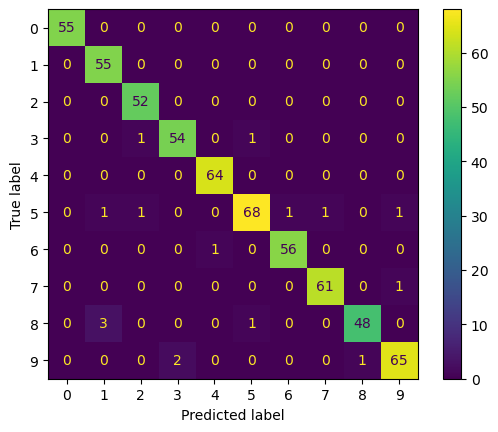

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model using classification report and confusion matrix
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

In [19]:
# Make predictions using the trained model
y_pred_train = predict(X_train, params)

# Calculate and print the accuracy score on the training set
accuracy_train = np.mean(y_pred_train == y_train.argmax(axis=0))
print(f'Training Accuracy: {accuracy_train}')

Training Accuracy: 1.0


In [20]:
# Calculate and print the accuracy score on the test set
accuracy_test = np.mean(y_pred == y_test)
print(f'Test Accuracy: {accuracy_test}')

Test Accuracy: 0.9730639730639731


In [21]:
def find_closest_factors(number):
    """
    Find the closest factors of a number.
    
    Arguments:
    number -- input number
    
    Returns:
    a -- one factor
    b -- another factor
    """
    a = int(np.sqrt(number))
    for i in range(a, 0, -1):
        if number % i == 0:
            return i, number // i

In [22]:
# Calculate the number of misclassifications
errors = np.sum(y_test != y_pred)

# Find and print the closest factors of the number of misclassifications
a, b = find_closest_factors(errors)
print(f'Number of Misclassifications: {errors} = {a} * {b}')

Number of Misclassifications: 16 = 4 * 4


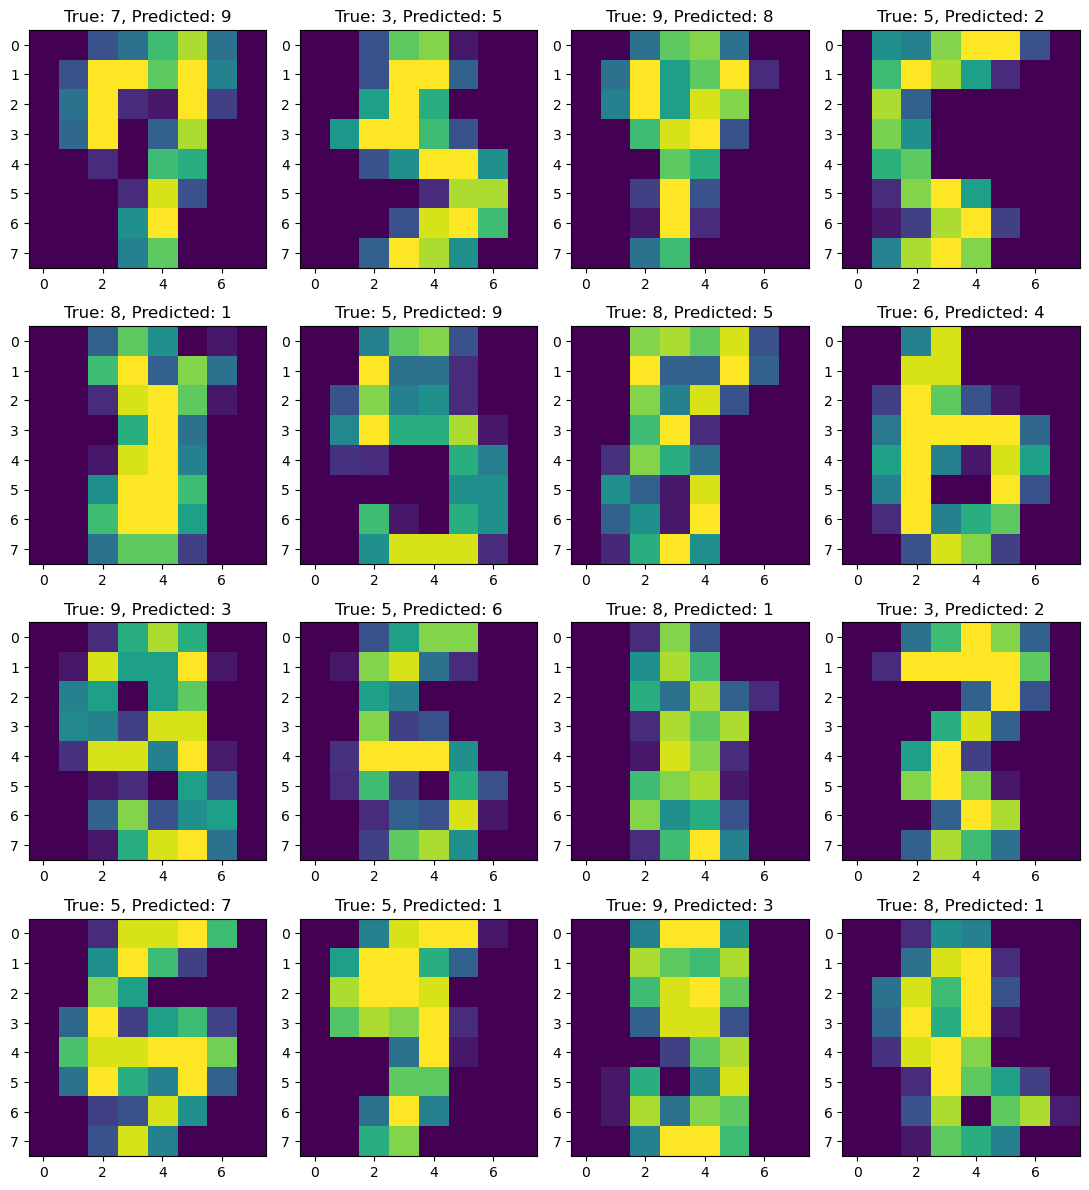

In [23]:
# Visualize some of the misclassified digits
# Plot a grid of images of misclassified digits along with their true and predicted labels
misclassified_indices = np.where(y_test != y_pred)[0]
num_misclassified = len(misclassified_indices)

# Create subplots for each misclassified digit
fig, axs = plt.subplots(a, b, figsize=(b*2.75, a*3))
for i, ax in enumerate(axs.flat):
    ax.imshow(X_test[:, misclassified_indices[i]].reshape(8, 8))
    ax.set_title(f'True: {y_test[misclassified_indices[i]]}, Predicted: {y_pred[misclassified_indices[i]]}')

# Show the plot
plt.tight_layout()
plt.show()

### training with lrarning rate decay without mini batch 

In [24]:
# Set hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 1000
LAYER_DIMS = [X_train.shape[0], 64, 32, y_train.shape[0]]  # Number of units in each layer

# Train the model and get the final parameters
params = nn_model(X_train, y_train, LAYER_DIMS, EPOCHS, LEARNING_RATE, 
                  batch_size=X_train.shape[1], decay_rate=2, print_cost=True)

Epoch: 0, Cost: 7.12809944152832
Epoch: 100, Cost: 5.024041652679443
Epoch: 200, Cost: 4.806312084197998
Epoch: 300, Cost: 4.798556327819824
Epoch: 400, Cost: 4.795986175537109
Epoch: 500, Cost: 4.79475212097168
Epoch: 600, Cost: 4.794048309326172
Epoch: 700, Cost: 4.79359769821167
Epoch: 800, Cost: 4.793283462524414
Epoch: 900, Cost: 4.793053150177002


In [25]:
# Make predictions using the trained model
y_pred = predict(X_test, params)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       0.96      1.00      0.98        55
           2       0.96      1.00      0.98        52
           3       0.96      0.96      0.96        56
           4       0.98      1.00      0.99        64
           5       0.96      0.93      0.94        73
           6       1.00      0.98      0.99        57
           7       0.98      0.98      0.98        62
           8       0.96      0.94      0.95        52
           9       0.97      0.96      0.96        68

    accuracy                           0.97       594
   macro avg       0.97      0.98      0.98       594
weighted avg       0.97      0.97      0.97       594



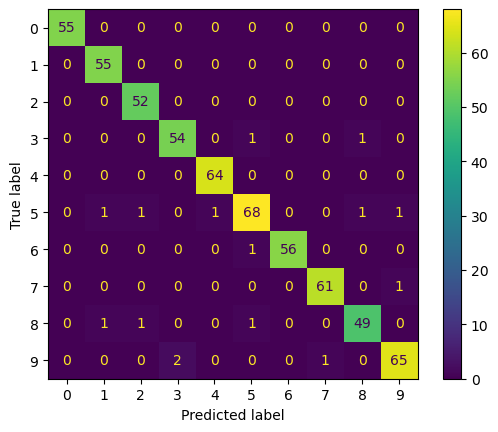

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model using classification report and confusion matrix
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

In [27]:
# Make predictions using the trained model
y_pred_train = predict(X_train, params)

# Calculate and print the accuracy score on the training set
accuracy_train = np.mean(y_pred_train == y_train.argmax(axis=0))
print(f'Training Accuracy: {accuracy_train}')

Training Accuracy: 1.0


In [28]:
# Calculate and print the accuracy score on the test set
accuracy_test = np.mean(y_pred == y_test)
print(f'Test Accuracy: {accuracy_test}')

Test Accuracy: 0.9747474747474747


In [29]:
# Calculate the number of misclassifications
errors = np.sum(y_test != y_pred)

# Find and print the closest factors of the number of misclassifications
a, b = find_closest_factors(errors)
print(f'Number of Misclassifications: {errors} = {a} * {b}')

Number of Misclassifications: 15 = 3 * 5


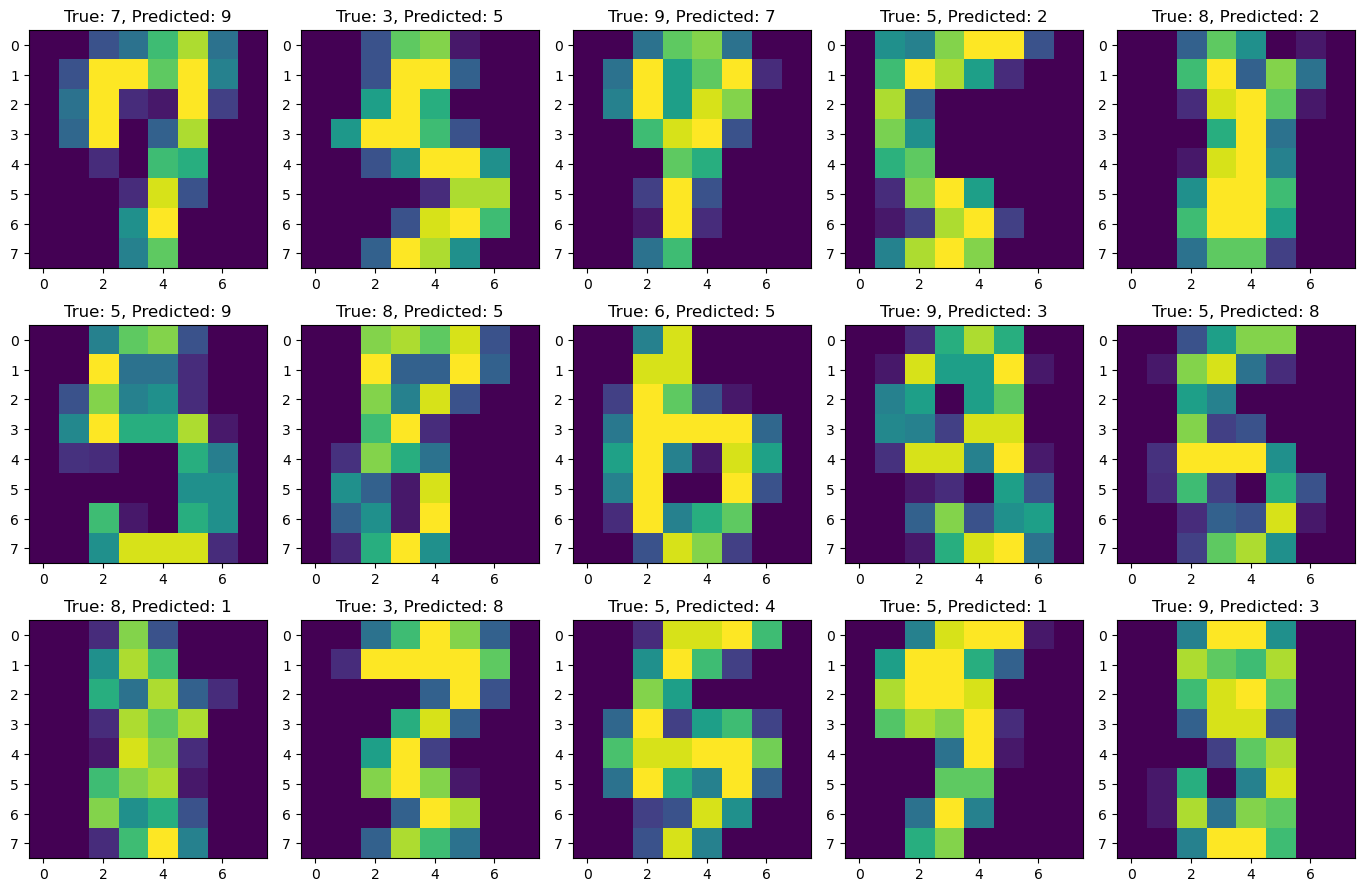

In [30]:
# Visualize some of the misclassified digits
# Plot a grid of images of misclassified digits along with their true and predicted labels
misclassified_indices = np.where(y_test != y_pred)[0]
num_misclassified = len(misclassified_indices)

# Create subplots for each misclassified digit
fig, axs = plt.subplots(a, b, figsize=(b*2.75, a*3))
for i, ax in enumerate(axs.flat):
    ax.imshow(X_test[:, misclassified_indices[i]].reshape(8, 8))
    ax.set_title(f'True: {y_test[misclassified_indices[i]]}, Predicted: {y_pred[misclassified_indices[i]]}')

# Show the plot
plt.tight_layout()
plt.show()